# NASA POWER API - Solar Irradiance Data

This notebook retrieves yearly average solar power irradiance data from NASA's POWER API.

In [18]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json
import json
from datetime import datetime

In [32]:
# Define your parameters:
latitude = 40.0    # Example latitude
longitude = -90.0  # Example longitude

year = 2023
num_years = 2

start_date = year-num_years + 1  # Format: YYYYMM for monthly data
end_date = year    # Format: YYYYMM for monthly data

# Define the parameter(s) you want (here global horizontal irradiance)
parameters = "ALLSKY_SFC_SW_DWN"

# Construct the API URL
url = (
    f"https://power.larc.nasa.gov/api/temporal/monthly/point?"
    f"parameters={parameters}&"
    f"community=RE&"
    f"longitude={longitude}&"
    f"latitude={latitude}&"
    f"start={start_date}&"
    f"end={end_date}&"
    f"format=JSON"
)

# Make the API call
response = requests.get(url)

# Check if the call was successful
if response.status_code == 200:
    data = response.json()
    # Print the result in a formatted way
    print(json.dumps(data, indent=2))
    
else:
    print("Error:", response.status_code, response.text)

{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [
      -90.0,
      40.0,
      172.74
    ]
  },
  "properties": {
    "parameter": {
      "ALLSKY_SFC_SW_DWN": {
        "202201": 2.14,
        "202202": 2.85,
        "202203": 3.71,
        "202204": 4.46,
        "202205": 5.21,
        "202206": 6.9,
        "202207": 5.99,
        "202208": 5.58,
        "202209": 4.68,
        "202210": 3.76,
        "202211": 2.4,
        "202212": 1.3,
        "202213": 4.08,
        "202301": 1.36,
        "202302": 2.88,
        "202303": 3.48,
        "202304": 5.43,
        "202305": 6.5,
        "202306": 6.55,
        "202307": 6.52,
        "202308": 5.5,
        "202309": 4.47,
        "202310": 3.1,
        "202311": 2.67,
        "202312": 1.47,
        "202313": 4.16
      }
    }
  },
  "header": {
    "title": "NASA/POWER Source Native Resolution Monthly and Annual",
    "api": {
      "version": "v2.6.7",
      "name": "POWER Monthly and Annual API

## Set up API parameters

The ALLSKY_SFC_SW_DWN parameter represents the all-sky surface downward shortwave irradiance (W/m²).

In [20]:
# Define location (Brazil)
latitude = -10.7833
longitude = -53.08334

# NASA POWER API parameters
base_url = "https://power.larc.nasa.gov/api/temporal/monthly/point"
parameters = "ALLSKY_SFC_SW_DWN"  # Solar irradiance at surface level (W/m²)

# Build the full API request URL
params = {
    "parameters": parameters,
    "community": "RE",  # Renewable Energy community
    "longitude": longitude,
    "latitude": latitude,
    "start": start_date,
    "end": end_date,
    "format": "JSON"
}

print(f"Retrieving solar irradiance data for coordinates ({latitude}, {longitude}) for year {year-1}")

Retrieving solar irradiance data for coordinates (-10.7833, -53.08334) for year 2022


## Make API request and process the data

In [21]:
# Make the API request
response = requests.get(base_url, params=params)

if response.status_code == 200:
    data = response.json()
    
    # Extract the solar irradiance data
    irradiance_data = data['properties']['parameter']['ALLSKY_SFC_SW_DWN']
    
    # Convert to DataFrame for easier processing
    df = pd.DataFrame(list(irradiance_data.items()), columns=['Date', 'Irradiance'])
    
    # Calculate yearly average
    yearly_avg = df['Irradiance'].mean()
    
    print(f"\nYearly average solar irradiance: {yearly_avg:.2f} W/m²")
    
    # Display first few rows of data
    print("\nSample of daily irradiance data:")
    print(df.head())
else:
    print(f"Error fetching data: {response.status_code}")
    print(response.text)


Yearly average solar irradiance: 5.49 W/m²

Sample of daily irradiance data:
     Date  Irradiance
0  201401        5.51
1  201402        4.77
2  201403        4.84
3  201404        5.22
4  201405        5.23


## Visualize monthly averages

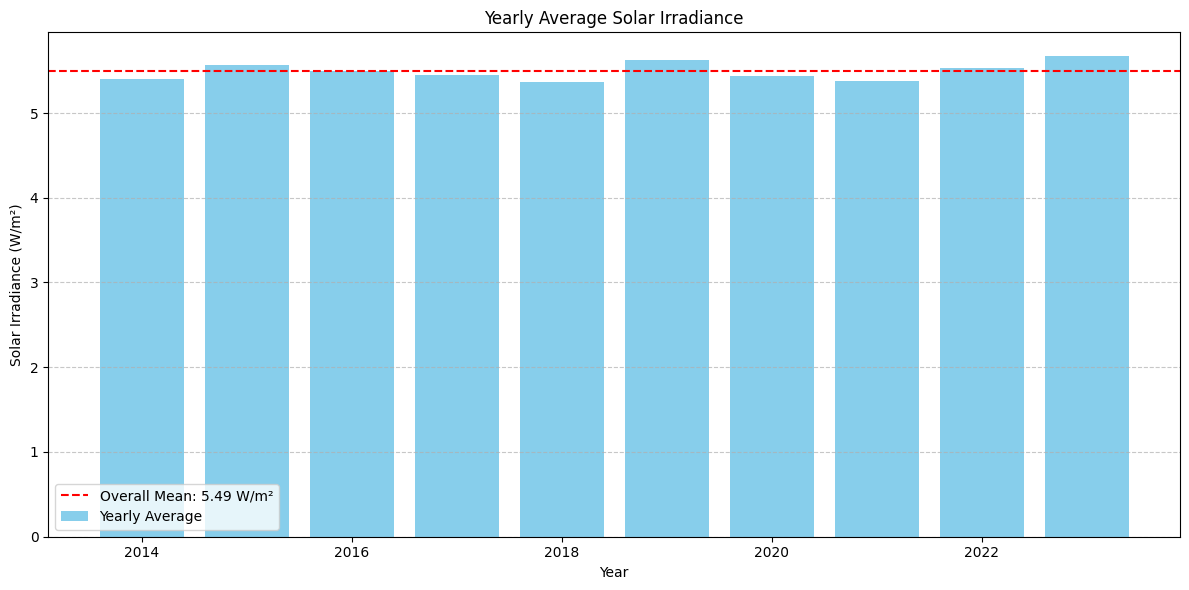

In [22]:
# Data processing and visualization
if response.status_code == 200:
    # Add year column by extracting year from Date
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%M')
    df['Year'] = df['Date'].dt.year
    
    # Extract month for plotting
    df['Month'] = df['Date'].dt.month
    
    # Calculate yearly averages for each year in the dataset
    yearly_avgs = df.groupby('Year')['Irradiance'].mean().reset_index()
    
    # Calculate overall mean across all years
    overall_mean = yearly_avgs['Irradiance'].mean()
    
    # Plot yearly averages
    plt.figure(figsize=(12, 6))
    plt.bar(yearly_avgs['Year'], yearly_avgs['Irradiance'], color='skyblue', label='Yearly Average')
    
    # Add a horizontal line for the mean
    plt.axhline(y=overall_mean, color='red', linestyle='--', label=f'Overall Mean: {overall_mean:.2f} W/m²')
        
    plt.title(f'Yearly Average Solar Irradiance')
    plt.xlabel('Year')
    plt.ylabel('Solar Irradiance (W/m²)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Geographic Visualization of Solar Irradiance

This section fetches solar irradiance data for a grid of locations and visualizes it on a map.

In [23]:
import folium
import numpy as np
from folium.plugins import HeatMap
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

In [24]:
# Resolution of the grid (lower = higher resolution but more API calls)
resolution = 5.0 # degrees

In [25]:
# Creating a grid of coordinates
min_lat, max_lat = -50, 10
min_lon, max_lon = -90, -20

# Generate grid coordinates
lats = np.arange(min_lat, max_lat + resolution, resolution)
lons = np.arange(min_lon, max_lon + resolution, resolution)

print(f"Grid size: {len(lats)}x{len(lons)} = {len(lats)*len(lons)} points")

# Create list of coordinate pairs
coordinates = [(lat, lon) for lat in lats for lon in lons]

# Show sample of coordinates that will be queried
print(f"Sample coordinates: {coordinates[:5]}")

Grid size: 13x15 = 195 points
Sample coordinates: [(np.float64(-50.0), np.float64(-90.0)), (np.float64(-50.0), np.float64(-85.0)), (np.float64(-50.0), np.float64(-80.0)), (np.float64(-50.0), np.float64(-75.0)), (np.float64(-50.0), np.float64(-70.0))]


In [ ]:
def fetch_regional_monthly_avg_irradiance(lat, lon, year, region_size=0.5):
    """
    Fetch yearly average solar irradiance for a region around a location
    
    Args:
        lat (float): Central latitude of the region
        lon (float): Central longitude of the region
        year (int): Target year for data collection
        region_size (float): Size of the region in degrees (default: 0.5)
        
    Returns:
        tuple: (lat, lon, avg_irradiance) - center coordinates and average irradiance
    """
    start_date = year-9
    end_date = year
    
    # Define region boundaries around the central point
    lat_min = lat - region_size
    lat_max = lat + region_size
    lon_min = lon - region_size
    lon_max = lon + region_size
    
    params = {
        "parameters": "ALLSKY_SFC_SW_DWN",
        "community": "RE",
        "latitude-min": lat_min,
        "latitude-max": lat_max,
        "longitude-min": lon_min,
        "longitude-max": lon_max,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }
    
    try:
        response = requests.get("https://power.larc.nasa.gov/api/temporal/monthly/regional", params=params)
        
        if response.status_code == 200:
            data = response.json()
            
            # Extract monthly irradiance values from the regional data
            # Note: The structure may need adjustment based on actual API response
            irradiance_values = []
            for feature in data.get('features', []):
                properties = feature.get('properties', {})
                parameter_data = properties.get('parameter', {}).get('ALLSKY_SFC_SW_DWN', {})
                if parameter_data:
                    irradiance_values.extend(list(parameter_data.values()))
            
            # Calculate average irradiance if we have data
            if irradiance_values:
                avg_irradiance = sum(irradiance_values) / len(irradiance_values)
                return lat, lon, avg_irradiance
            else:
                print(f"No irradiance data found for region around ({lat}, {lon})")
                return lat, lon, None
        else:
            print(f"Error for region around ({lat}, {lon}): {response.status_code}")
            return lat, lon, None
    except Exception as e:
        print(f"Exception for region around ({lat}, {lon}): {str(e)}")
        return lat, lon, None

In [ ]:
# Year to analyze
year = 2023

# Limit the number of points to fetch (to avoid API rate limits)
max_points = len(lats) * len(lons)

coordinates

print(f"Fetching data for {len(coordinates)} locations for year {year}...")

# Fetch data using multithreading to speed up the process
results = []
with ThreadPoolExecutor(max_workers=None) as executor:
    futures = [executor.submit(fetch_yearly_avg_irradiance, lat, lon, year) 
              for lat, lon in coordinates]
    
    for future in tqdm(futures):
        results.append(future.result())

# Filter out any failed requests
valid_results = [(lat, lon, avg) for lat, lon, avg in results if avg is not None]

print(f"Successfully retrieved data for {len(valid_results)} out of {len(coordinates)} locations")

# Extract data for visualization
map_data = [(lat, lon, avg) for lat, lon, avg in valid_results]

# Create DataFrame from results
irradiance_df = pd.DataFrame(map_data, columns=['latitude', 'longitude', 'irradiance'])
irradiance_df.head()

Fetching data for 195 locations for year 2023...


  0%|          | 0/195 [00:00<?, ?it/s]

Successfully retrieved data for 195 out of 195 locations


,latitude,longitude,irradiance
0,-50.0,-90.0,3.035542
1,-50.0,-85.0,3.043316
2,-50.0,-80.0,2.938735
3,-50.0,-75.0,2.457360
4,-50.0,-70.0,3.816961


In [28]:
# Create a map centered on the region
center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Add irradiance data as a heat map layer
heat_data = [[row['latitude'], row['longitude'], row['irradiance']] for _, row in irradiance_df.iterrows()]

# Normalize values for better visualization
min_irr = min(irradiance_df['irradiance'])
max_irr = max(irradiance_df['irradiance'])
normalized_heat_data = [[lat, lon, (irr - min_irr) / (max_irr - min_irr) * 100] 
                        for lat, lon, irr in heat_data]

# Fix: Convert float keys to strings in the gradient dictionary
HeatMap(normalized_heat_data, radius=15, max_zoom=10, gradient={"0.4": 'blue', "0.65": 'lime', "1": 'red'}).add_to(m)

# Also add markers with actual values
for _, row in irradiance_df.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=5,
        popup=f"Irradiance: {row['irradiance']:.2f} W/m²",
        color='blue',
        fill=True
    ).add_to(m)

# Add a title
title_html = '''
    <h3 align="center" style="font-size:16px"><b>
    Yearly Average Solar Irradiance ({}) W/m²
    </b></h3>
'''.format(year)

m.get_root().html.add_child(folium.Element(title_html))

# Display the map
m

In [29]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from scipy.interpolate import griddata


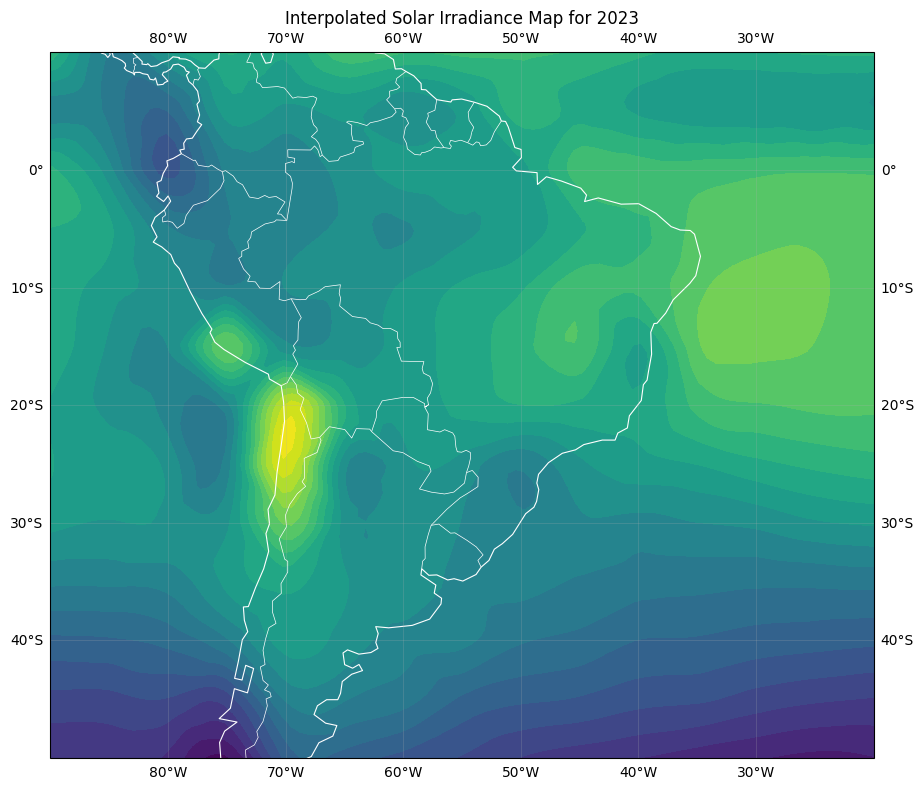

In [30]:
# Create a finer grid for interpolation
grid_lat = np.linspace(min_lat, max_lat, 100)
grid_lon = np.linspace(min_lon, max_lon, 100)
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

# Interpolate data - Important: Note the order of coordinates for proper interpolation
points = irradiance_df[['longitude', 'latitude']].values
values = irradiance_df['irradiance'].values
# Use the same coordinate order for sample points and grid points
grid_irr = griddata(points, values, (grid_lon, grid_lat), method='cubic')

# Create a new plot
fig, ax = plt.subplots(figsize=(12, 8))
# Plot with longitude on X-axis and latitude on Y-axis for correct geospatial orientation
contour = plt.contourf(grid_lon, grid_lat, grid_irr, cmap='viridis', levels=20)
plt.colorbar(contour, label='Solar Irradiance (W/m²)')

# Add scatter points of actual data
# Add terrestrial borders using cartopy or geopandas

# Close the previous figure to avoid overlay issues
plt.close(fig)

# Create a new figure with proper cartopy projection from the beginning
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the contour on the cartopy axes with proper projection
contour = ax.contourf(grid_lon, grid_lat, grid_irr, cmap='viridis', 
                        levels=20, transform=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, edgecolor='white', linewidth=0.8)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.5)

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3)

# Set extent based on our data bounds
ax.set_extent([min_lon, max_lon, min_lat, max_lat], ccrs.PlateCarree())
# ax.set_position(ax_new.get_position())
# ax_new.set_position(ax.get_position())

plt.title(f'Interpolated Solar Irradiance Map for {year}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()